In [27]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt 
import itertools
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count, mean as _mean, stddev as _stddev, col
from pyspark.sql.types import DoubleType, IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, IndexToString, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [28]:
spark = SparkSession.builder \
                .appName('TestMinadzb') \
                .config("spark.driver.bindAddress", "127.0.0.1") \
                .getOrCreate()

In [29]:
csv = spark.read.format("csv").option("header","true").load("dataset.csv")

In [30]:
csv.head()

Row(url='https://bj.lianjia.com/chengjiao/101084782030.html', id='101084782030', Lng='116.475489', Lat='40.01952', Cid='1111027376244', tradeTime='2016-08-09', DOM='1464', followers='106', totalPrice='415.0', price='31680', square='131.0', livingRoom='2', drawingRoom='1', kitchen='1', bathRoom='1', floor='�� 26', buildingType='1', constructionTime='2005', renovationCondition='3', buildingStructure='6', ladderRatio='0.217', elevator='1.0', fiveYearsProperty='0.0', subway='1.0', district='7', communityAverage='56021')

In [31]:
csv.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in csv.columns]
   ).show()

+---+---+---+---+---+---------+------+---------+----------+-----+------+----------+-----------+-------+--------+-----+------------+----------------+-------------------+-----------------+-----------+--------+-----------------+------+--------+----------------+
|url| id|Lng|Lat|Cid|tradeTime|   DOM|followers|totalPrice|price|square|livingRoom|drawingRoom|kitchen|bathRoom|floor|buildingType|constructionTime|renovationCondition|buildingStructure|ladderRatio|elevator|fiveYearsProperty|subway|district|communityAverage|
+---+---+---+---+---+---------+------+---------+----------+-----+------+----------+-----------+-------+--------+-----+------------+----------------+-------------------+-----------------+-----------+--------+-----------------+------+--------+----------------+
|  0|  0|  0|  0|  0|        0|157977|        0|         0|    0|     0|         0|          0|      0|       0|    0|        2021|               0|                  0|                0|          0|      32|               3

In [32]:
csv = csv.drop('url')
csv = csv.drop('cid')
csv = csv.drop('id')
csv = csv.drop('Lng')
csv = csv.drop('Lat')
csv = csv.drop('DOM')
csv = csv.drop('tradeTime')
csv = csv.drop('price')
csv = csv.drop('floor') #(chinese characters)
csv = csv.drop('buildingType') #buildingType
csv = csv.drop('communityAverage') #communityAverage
csv = csv.drop('constructionTime') #constructionTime (chinese characters)

In [33]:
csv = csv.dropna()

In [34]:
csv.describe()

DataFrame[summary: string, followers: string, totalPrice: string, square: string, livingRoom: string, drawingRoom: string, kitchen: string, bathRoom: string, renovationCondition: string, buildingStructure: string, ladderRatio: string, elevator: string, fiveYearsProperty: string, subway: string, district: string]

In [35]:
csv.printSchema()

root
 |-- followers: string (nullable = true)
 |-- totalPrice: string (nullable = true)
 |-- square: string (nullable = true)
 |-- livingRoom: string (nullable = true)
 |-- drawingRoom: string (nullable = true)
 |-- kitchen: string (nullable = true)
 |-- bathRoom: string (nullable = true)
 |-- renovationCondition: string (nullable = true)
 |-- buildingStructure: string (nullable = true)
 |-- ladderRatio: string (nullable = true)
 |-- elevator: string (nullable = true)
 |-- fiveYearsProperty: string (nullable = true)
 |-- subway: string (nullable = true)
 |-- district: string (nullable = true)



In [36]:
csv.show()

+---------+----------+------+----------+-----------+-------+--------+-------------------+-----------------+-----------+--------+-----------------+------+--------+
|followers|totalPrice|square|livingRoom|drawingRoom|kitchen|bathRoom|renovationCondition|buildingStructure|ladderRatio|elevator|fiveYearsProperty|subway|district|
+---------+----------+------+----------+-----------+-------+--------+-------------------+-----------------+-----------+--------+-----------------+------+--------+
|      106|     415.0| 131.0|         2|          1|      1|       1|                  3|                6|      0.217|     1.0|              0.0|   1.0|       7|
|      126|     575.0|132.38|         2|          2|      1|       2|                  4|                6|      0.667|     1.0|              1.0|   0.0|       7|
|       48|    1030.0| 198.0|         3|          2|      1|       3|                  3|                6|        0.5|     1.0|              0.0|   0.0|       7|
|      138|     297.5|

In [37]:


to_int = ['followers', 'livingRoom', 'drawingRoom', 'kitchen',
          'bathRoom', 'renovationCondition', 'buildingStructure', 
          'elevator', 'fiveYearsProperty', 'subway', 'district']
to_double = ['square', 'ladderRatio', 'totalPrice']

for i in to_int:
    csv = csv.withColumn(i,col(i).cast(IntegerType()))
    #csv = csv.select(col(i).cast('int').alias(i))
    
for i in to_double:
    csv = csv.withColumn(i,col(i).cast(DoubleType()))
    #csv = csv.select(col(i).cast('double').alias(i))

In [38]:
#do kategoryzacji podzial ceny na duze i male
df_stats = csv.select(
    _mean(col('totalPrice')).alias('mean'),
    _stddev(col('totalPrice')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']
mean

349.0515326878279

In [39]:
#do kategoryzacji podzial ceny na duze i male
csv2 = csv.withColumn("totalPrice", when(csv.totalPrice >= 350,1) 
#                                     .when(csv.totalPrice >= 500,2) 
#                                     .when(csv.totalPrice >= 350,1) 
                                    .otherwise(0))
csv2.show(15,False)

+---------+----------+------+----------+-----------+-------+--------+-------------------+-----------------+-----------+--------+-----------------+------+--------+
|followers|totalPrice|square|livingRoom|drawingRoom|kitchen|bathRoom|renovationCondition|buildingStructure|ladderRatio|elevator|fiveYearsProperty|subway|district|
+---------+----------+------+----------+-----------+-------+--------+-------------------+-----------------+-----------+--------+-----------------+------+--------+
|106      |1         |131.0 |2         |1          |1      |1       |3                  |6                |0.217      |1       |0                |1     |7       |
|126      |1         |132.38|2         |2          |1      |2       |4                  |6                |0.667      |1       |1                |0     |7       |
|48       |1         |198.0 |3         |2          |1      |3       |3                  |6                |0.5        |1       |0                |0     |7       |
|138      |0         |

In [40]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=csv.columns, outputCol=vector_col)
df_vector = assembler.transform(csv).select(vector_col)

# get correlation matrix
corr = Correlation.corr(df_vector, vector_col)
# corr.style.background_gradient(cmap='coolwarm')
# cor_np = corr.collect()[0][corr.columns[0]].toArray()
# print(str(corr).replace('nan', 'NaN'))
corr.collect()[0]["pearson({})".format(vector_col)].values

/usr/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([ 1.00000000e+00,  1.52645902e-01, -5.08269143e-02, -6.57602064e-03,
       -5.39928849e-02,  9.10016082e-03, -3.42559962e-02,  2.41063004e-01,
       -2.27037778e-02, -2.00301910e-04, -2.07609856e-02,  4.96317807e-02,
        1.82434638e-02, -3.24042027e-02,  1.52645902e-01,  1.00000000e+00,
        5.75844775e-01,  4.34312367e-01,  3.22706262e-01,  8.64251458e-02,
        4.42432735e-01,  2.50776646e-01,  1.87961612e-01, -1.06371667e-03,
        1.92344785e-01, -3.22497345e-03,  1.13183328e-01,  1.03828020e-02,
       -5.08269143e-02,  5.75844775e-01,  1.00000000e+00,  7.22672921e-01,
        6.16364488e-01,  9.11690035e-02,  7.38126734e-01,  3.14778680e-02,
        1.56220097e-01, -2.42038252e-03,  1.68130705e-01, -1.81643868e-02,
       -9.49727894e-02, -7.33993010e-03, -6.57602064e-03,  4.34312367e-01,
        7.22672921e-01,  1.00000000e+00,  4.89589466e-01,  1.00451606e-01,
        5.52904210e-01,  1.02750923e-02, -6.47624454e-02, -3.25542094e-03,
       -7.82711917e-02,  

# Klasyfikacja

# przygotowanie danych

In [41]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [42]:
#do zriobienia dla danych kategorycznych
catcols = ['renovationCondition','buildingStructure','elevator','fiveYearsProperty',
           'subway']

num_cols = ['followers','square','livingRoom','drawingRoom','kitchen','bathRoom','ladderRatio','district']
labelCol = 'totalPrice'

data = get_dummy(csv2,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,1.0,1.0,...|    1|
|[0.0,1.0,0.0,1.0,...|    1|
|(19,[2,3,8,11,12,...|    1|
|(19,[0,3,8,11,12,...|    0|
|(19,[4,9,10,11,12...|    1|
+--------------------+-----+
only showing top 5 rows



In [43]:

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[0.0,0.0,1.0,1.0,...|    1|         1.0|
|[0.0,1.0,0.0,1.0,...|    1|         1.0|
|(19,[2,3,8,11,12,...|    1|         1.0|
|(19,[0,3,8,11,12,...|    0|         0.0|
|(19,[4,9,10,11,12...|    1|         1.0|
+--------------------+-----+------------+
only showing top 5 rows



In [44]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 6 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=5).fit(data)
featureIndexer.transform(data).show(6, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[0.0,0.0,1.0,1.0,...|    1|[0.0,0.0,1.0,1.0,...|
|[0.0,1.0,0.0,1.0,...|    1|[0.0,1.0,0.0,1.0,...|
|(19,[2,3,8,11,12,...|    1|(19,[2,3,8,11,12,...|
|(19,[0,3,8,11,12,...|    0|(19,[0,3,8,11,12,...|
|(19,[4,9,10,11,12...|    1|(19,[4,9,10,11,12...|
|(19,[2,3,8,9,11,1...|    0|(19,[2,3,8,9,11,1...|
+--------------------+-----+--------------------+
only showing top 6 rows



In [45]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------------------------------------+-----+
|features                                                                               |label|
+---------------------------------------------------------------------------------------+-----+
|(19,[0,3,8,9,10,11,12,13,16,17,18],[1.0,1.0,1.0,1.0,1.0,71.0,37.0,1.0,1.0,0.047,7.0])  |0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,10.0,49.0,1.0,1.0,1.0,0.5,6.0])    |0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,18.0,43.98,1.0,1.0,1.0,0.25,10.0]) |0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,29.0,47.33,1.0,1.0,1.0,0.25,2.0])  |0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,44.0,40.42,1.0,1.0,1.0,0.222,10.0])|0    |
+---------------------------------------------------------------------------------------+-----+
only showing top 5 rows



+-------------------------------------------------------------------------------------+-----+
|features                                                                             |label|
+-------------------------------------------------------------------------------------+-----+
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,1.0,56.0,1.0,1.0,1.0,0.125,7.0]) |0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,3.0,56.22,1.0,1.0,1.0,0.273,2.0])|0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,5.0,46.4,1.0,1.0,1.0,0.25,8.0])  |1    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,17.0,39.4,1.0,1.0,1.0,0.167,7.0])|0    |
|(19,[0,3,8,9,11,12,13,15,16,17,18],[1.0,1.0,1.0,1.0,18.0,50.0,1.0,1.0,1.0,0.667,9.0])|0    |
+-------------------------------------------------------------------------------------+-----+
only showing top 5 rows



# Regresja Logistyczna

In [46]:
# Logistic regression model
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [47]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    1|             0|
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    0|             0|
+--------------------+-----+--------------+
only showing top 5 rows



In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.249783


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|1.090165034214410...|0.002384804195023...|
|1.761035824500201...|0.004839339506861542|
|2.264188917214544...|0.007321767265424523|
|3.354353951428955E-4| 0.00970657146044851|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.8148416454357418


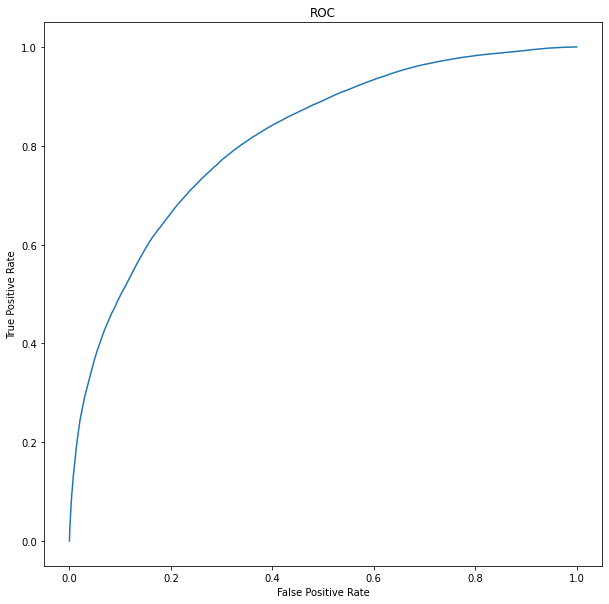

In [49]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

print(trainingSummary)

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)



x = trainingSummary.roc.select("FPR")
x = x.toPandas()
y = trainingSummary.roc.select("TPR")
y = y.toPandas()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("ROC")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot(x,y)

# Drzewo Decyzyjne

In [53]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [54]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    1|             0|
|(19,[0,3,8,9,11,1...|    0|             0|
|(19,[0,3,8,9,11,1...|    0|             1|
+--------------------+-----+--------------+
only showing top 5 rows



In [55]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.230192
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0c884ff25be6, depth=5, numNodes=51, numClasses=2, numFeatures=19
